In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances


from utils import load_dict

data_dir = "./data"
plot_dir = "./plots"

In [2]:
def get_E_H(xi, λi):
    """Get electric far field components for horizontally orientated dipole.

    Args:
        xi (int): index of the spatial displacement
        λi (int): index of the wavelength

    Returns:
        number of data points, E_x, E_y, E_z
    """
    result_E_zp_farfield = load_dict(f'{data_dir}/0deg/result_E_xp_farfield_n201_cartesian_x_{xi}.pkl')
    n = result_E_zp_farfield.shape[0]
    E_x, E_y, E_z = result_E_zp_farfield[:, :, 0, λi], result_E_zp_farfield[:, :, 1, λi], result_E_zp_farfield[:, :, 2, λi]
    return (n, E_y, E_z, E_x) # permuted because of Simon's rotation in the simulation file!

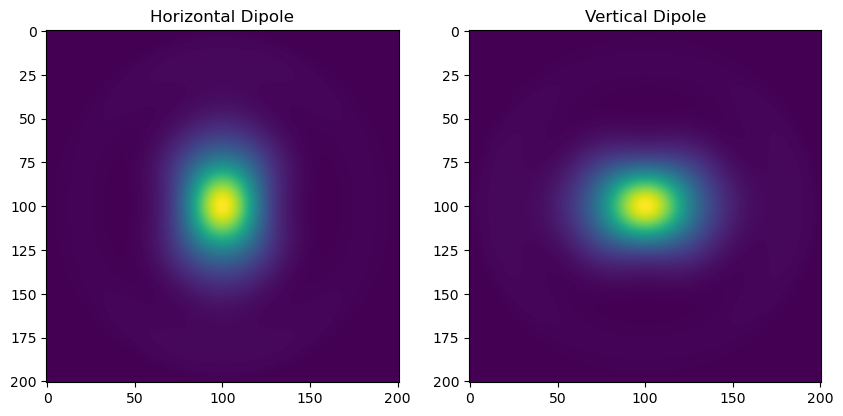

In [3]:
# Load electric field components for horizontally and vertically
# orientated dipole from simulation results
n, E_H_x, E_H_y, E_H_z = get_E_H(1, 84) # xi = 1 is no spatial displacement, λi = 84 is 930 nm wavelength
# since everything is perfectly symmetric (no displacement, no ellipticity),
# we can just rotate the field by 90° to get the field emitted by a vertical dipole 
# this way we only need one single FDTD simulation! (and reduce errors due to numerical inaccuracies in the simulation)
# rotation is performed by swapping the x and y components and transposing all components
_, E_V_x, E_V_y, E_V_z = n, E_H_y.T, E_H_x.T, E_H_z.T # get_E_V(1, 84) 


# Plot field intensity of the horizontally and vertically orientated dipoles, respectively
# as a sanity check
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.abs(E_H_x)**2 + np.abs(E_H_y)**2 + np.abs(E_H_z)**2)
axs[0].set_title('Horizontal Dipole')
axs[1].imshow(np.abs(E_V_x)**2 + np.abs(E_V_y)**2 + np.abs(E_V_z)**2)
axs[1].set_title('Vertical Dipole')
plt.show()

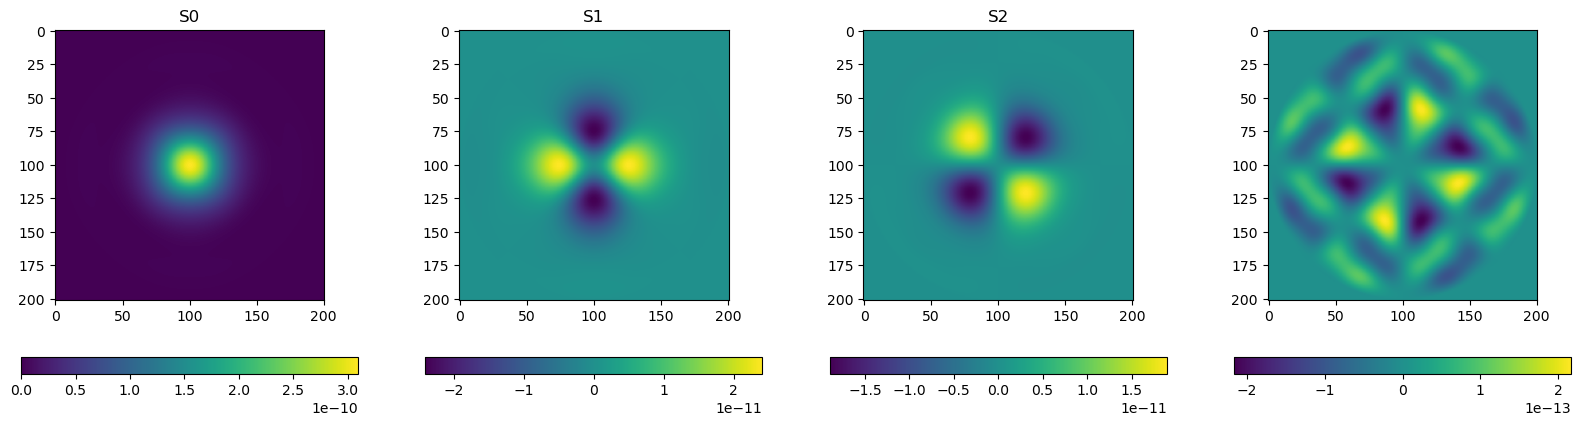

C:\Users\fkt25ya\AppData\Local\Temp\ipykernel_14400\2437509120.py:27: RuntimeWarning: invalid value encountered in divide
  S1norm = S1 / S0
C:\Users\fkt25ya\AppData\Local\Temp\ipykernel_14400\2437509120.py:28: RuntimeWarning: invalid value encountered in divide
  S2norm = S2 / S0
C:\Users\fkt25ya\AppData\Local\Temp\ipykernel_14400\2437509120.py:29: RuntimeWarning: invalid value encountered in divide
  S3norm = S3 / S0


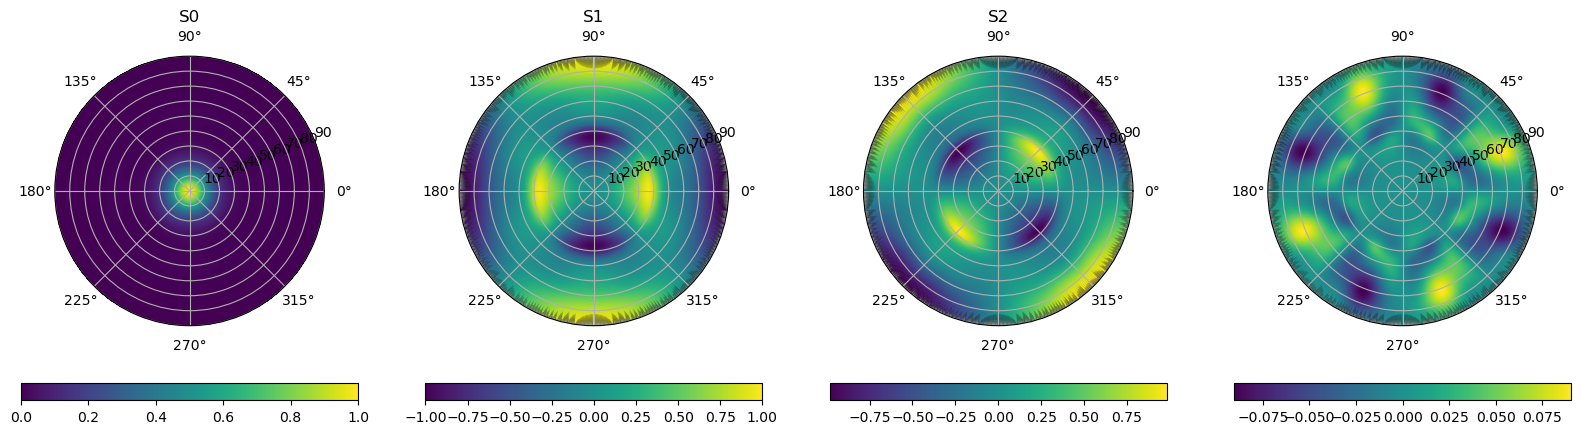

In [4]:

# Calculate Stokes parameters from the farfield components
# see https://optics.ansys.com/hc/en-us/articles/1500006080761-Incoherent-unpolarized-dipole for details
# or my Master's thesis, ch. 7
S0 = (np.abs(E_H_x)**2 + np.abs(E_V_x)**2) + (np.abs(E_H_y)**2 + np.abs(E_V_y)**2)
S1 = (np.abs(E_H_x)**2 + np.abs(E_V_x)**2) - (np.abs(E_H_y)**2 + np.abs(E_V_y)**2)
S2 =  2 * np.real( E_H_x * np.conjugate(E_H_y) + E_V_x * np.conjugate(E_V_y) )
S3 = -2 * np.imag( E_H_x * np.conjugate(E_H_y) + E_V_x * np.conjugate(E_V_y) )

# Plot Stokes parameters as a sanity check
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
ims = []
ims.append( axs[0].imshow(S0.T) )
axs[0].set_title('S0')
ims.append( axs[1].imshow(S1.T) )
axs[1].set_title('S1')
ims.append( axs[2].imshow(S2.T) ) 
axs[2].set_title('S2')
ims.append( axs[3].imshow(S3.T) )
for (im, ax) in zip(ims, axs):
    plt.colorbar(im, ax=ax, orientation='horizontal')
plt.show()

# And again, but as polar plots and normalized to the intensity
S0norm = S0 / np.max(S0)
# Artifacts at the boundardies for high angles are due to S0 being 0 (or close to) there
# ToDo: Think about what the proper way to normalize is?
S1norm = S1 / S0
S2norm = S2 / S0
S3norm = S3 / S0

# Coordinate transformation from Lumerical unit coordinates to usual polar coordinates
ux, uy = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
rs = [ [ (180/np.pi) * np.arccos(np.sqrt( 1 - ux[i]**2 - uy[j]**2)) if (ux[i]**2 + uy[j]**2) < 1 else 90 for j in range(n)] for i in range(n)]
phis = [ [np.arctan2(ux[i], uy[j]) for j in range(n)] for i in range(n)] # @TODO formular is uy/ux, but arctan2 inverts arg order, so it's like that?

fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw=dict(polar=True))
ims = []
ims.append( axs[0].pcolormesh(phis,rs, S0norm.T, rasterized=True, shading='gouraud') )
axs[0].set_title('S0')
ims.append( axs[1].pcolormesh(phis,rs, S1norm.T, rasterized=True, shading='gouraud') )
axs[1].set_title('S1')
ims.append( axs[2].pcolormesh(phis,rs, S2norm.T, rasterized=True, shading='gouraud') ) 
axs[2].set_title('S2')
ims.append( axs[3].pcolormesh(phis,rs, S3norm.T, rasterized=True, shading='gouraud') )
for (im, ax) in zip(ims, axs):
    plt.colorbar(im, ax=ax, orientation='horizontal')
plt.show()

Note: Normalization on local intensity is only used for visualization. Further calculations are globally normalized afterwards.

C:\Users\fkt25ya\AppData\Local\Temp\ipykernel_14400\3367769355.py:113: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


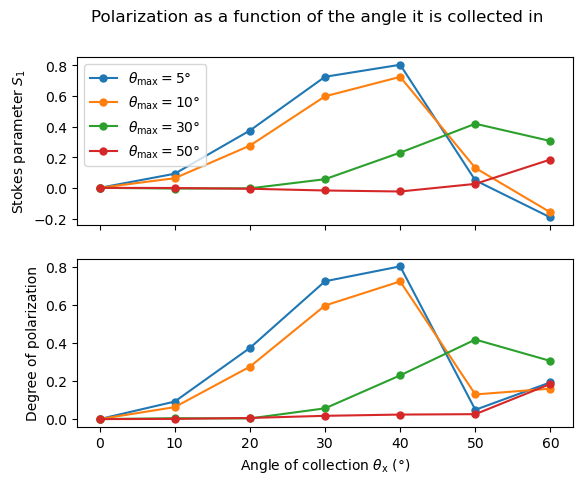

In [5]:
# Calculate degree of polarization for various given collection angles

def get_mask_for_cone(n, theta_x, theta_max):
    # See https://optics.ansys.com/hc/en-us/articles/360034394294-Understanding-direction-unit-vector-coordinates-in-far-field-projections
    # for details on the ux, uy coordinate system used here
    ux, uy = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    circular_mask = np.zeros( (n,n) )
    for i in range(n):
        for j in range(n):
            if ((ux[i]**2 + uy[j]**2) >= 1):
                circular_mask[i,j] = True
            else:
                uz = np.sqrt( 1 - ux[i]**2 - uy[j]**2)
                theta = np.arccos(uz)
                phi = np.arctan2(ux[j], uy[i])
                # calculate the angle (great circle distance) between the two points (ux, uy and collection given by theta_x, 0) on the hemisphere
                # deltaSigma = np.arccos( np.sin(np.pi/2 - theta_x) * np.sin(np.pi/2 - theta) + np.cos(np.pi/2 - theta_x) * np.cos(np.pi/2 - theta) * np.cos(np.pi - phi) )
                deltaSigma = haversine_distances( [[ np.pi/2 - theta, np.pi/2 + phi] , [np.pi/2 - theta_x * (np.pi/180), np.pi/2 + 0]] )
                circular_mask[i,j] = ( deltaSigma.max() > theta_max*(np.pi/180) )
    return circular_mask

def integrate_stokes_parameter_in_area(Si, mask):
    """Integrate a Stokes parameter over a given collection mask (e.g. a cone). Still should be normalized afterwards.

    Args:
        Si (array): Stokes parameter to integrate, spatially resolved
        mask (array): mask array, same shape as Si, False for points to integrate over, True for points to ignore

    Returns:
        float: Average of Stokes parameter in cone
    """
    masked_Si = np.ma.masked_array(Si, mask=mask)
    return masked_Si.sum()

def plot_mask(circular_mask, plot_title):
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
        # im = ax.imshow(circular_mask)
    ux, uy = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    rs = [ [ (180/np.pi) * np.arccos(np.sqrt( 1 - ux[i]**2 - uy[j]**2)) if (ux[i]**2 + uy[j]**2) < 1 else 90 for j in range(n)] for i in range(n)]
    phis = [ [np.arctan2(ux[i], uy[j]) for j in range(n)] for i in range(n)] # @TODO formular is uy/ux, but arctan2 inverts arg order, so it's like that?
    im = ax.pcolormesh(phis,rs, circular_mask.T, rasterized=True, shading='gouraud')
    fig.colorbar(im, ax=ax, orientation='horizontal')
    fig.suptitle(plot_title)
    plt.show()

def calc_normalized_stokes_parameter_in_cone(n, Si, S0, theta_x, theta_max):
    """Calculate the normalized Stokes parameter in a given collection cone.

    Args:
        n (int): Number of points in one dimension of the farfield grid
        Si (array): Stokes parameter to integrate, spatially resolved
        S0 (float): Total intensity for normalization, spatially resolved
        theta_max (float): Angle to integrate over

    Returns:
        float: Normalized Stokes parameter in cone
    """
    mask = get_mask_for_cone(n, theta_x, theta_max)
    # plot the mask for debugging
    # plot_mask(mask, f'Mask for $\\theta_\\mathrm{{x}}$ = {theta_x}° and $\\theta_\\mathrm{{max}} =$ {theta_max}°')
    S0int_cone = integrate_stokes_parameter_in_area(S0, mask)
    return integrate_stokes_parameter_in_area(Si, mask) / S0int_cone



def calc_dop_in_cone( n, S, theta_x, theta_max ):
    """
    Calculate the degree of polarization (DOP) for a given collection cone.

    Parameters:
    - n: The number of points in one dimension of the farfield grid.
    - S: The Stokes vector (S0, S1, S2, S3):
    - theta_x: The angle of collection, measured from the z-axis towards the x-axis.
    - theta_max: The angle of the cone to consider.

    Returns:
    The degree of polarization for the given angle range.
    """

    S0, S1, S2, S3 = S

    mask = get_mask_for_cone(n, theta_x, theta_max)
    # plot the mask for debugging
    # plot_mask(mask, f'Mask for $\\theta_\\mathrm{{x}}$ = {theta_x}° and $\\theta_\\mathrm{{max}} =$ {theta_max}°')
    S0int_cone = integrate_stokes_parameter_in_area(S0, mask)
    S1int_cone = integrate_stokes_parameter_in_area(S1, mask)
    S2int_cone = integrate_stokes_parameter_in_area(S2, mask)
    S3int_cone = integrate_stokes_parameter_in_area(S3, mask)

    dop = np.sqrt(S1int_cone**2 + S2int_cone**2 + S3int_cone**2) / S0int_cone

    return dop

# Plot the degree of polarization as a function of the collection angle
# Two axes above each other, one for the Stokes S1 parameter, one for the DOP
# ToDO currently pretty inefficient, speed up by e.g. masking more efficiently
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
theta_maxs = [5, 10, 30, 50]
theta_xs = [0, 10, 20, 30, 40, 50, 60]
for theta_max in theta_maxs:
    S1s = [calc_normalized_stokes_parameter_in_cone(n, S1, S0, theta_x, theta_max)
           for theta_x in theta_xs]
    dops = [calc_dop_in_cone(n, (S0, S1, S2, S3), theta_x, theta_max) for theta_x in theta_xs]
    ax1.plot(theta_xs, S1s, label=f'$\\theta_\\mathrm{{max}} = {theta_max}°$', marker = '.', markersize = 10)
    ax2.plot(theta_xs, dops, label=f'$\\theta_\\mathrm{{max}} = {theta_max}°$', marker = '.', markersize = 10)

ax2.set_xlabel('Angle of collection $\\theta_\\mathrm{x}$ (°)')
ax1.set_ylabel('Stokes parameter $S_1$')
ax2.set_ylabel('Degree of polarization')
fig.suptitle('Polarization as a function of the angle it is collected in')
ax1.legend()

fig.show()
fig.savefig(f'{plot_dir}/polarization_by_collection_angle.png')